# Preprocessing

## Een tokenizer maken met NLTK

Ik begin met het tokenizen van de trefwoorden.

In [28]:
import pandas as pd
import nltk
import numpy as np
import torch
from torch import nn
import time

intent_keuken = pd.read_csv("data/intent-keuken.csv")
intent_keuken.head()

,Keyword,Intentie
0,keuken,TRANS
1,koelkast,TRANS
2,inductie kookplaat,TRANS
3,afzuigkap,TRANS
4,vaatwasser,TRANS


Het commando nltk.download('punkt'); zal de NLTK downloader opstarten en hem vertellen de punkt data te installeren, wat een zin tokenizer is die een zin van woorden neemt en ze opbreekt in individuele waarden.

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Warmtebron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Om het gemakkelijker te maken tokenization toe te passen op onze Pandas dataframe kolom, en om ons in staat te stellen de functie te hergebruiken in andere NLP projecten die we misschien later zullen aanpakken, maken we een kleine functie. Deze neemt een Pandas kolomnaam en geeft een lijst van tokens terug van word_tokenize. De for-loop gebruikt isalpha() om waarden terug te geven in plaats van booleans.

In [30]:
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column (i.e. df['text']).

    Returns:
        tokens (list): Tokenized list, i.e. [Donald, Trump, tweets]
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

## Tekst data tokenen met NLTK

Het laatste wat we moeten doen is onze functie uitvoeren op de Pandas-tekstkolom, wat we kunnen doen met een lambda-functie op de verticale as (via axis=1). Deze voert de hele tekstkolom in, gebruikt NLTK om de waarden te tokenen, en geeft een nieuwe Pandas-kolom met de naam tokenized die Python-lijsten bevat met door komma's gescheiden tokens.

In [31]:
intent_keuken['tokenized'] = intent_keuken.apply(lambda x: tokenize(x['Keyword']), axis=1)
intent_keuken[['tokenized']].head()

,tokenized
0,[keuken]
1,[koelkast]
2,"[inductie, kookplaat]"
3,[afzuigkap]
4,[vaatwasser]


## Encoden

Nu ga ik de data tokens encoden. Hierbij worden er getallen gegeven aan ieder woord dat voor komt in de Main Topic kolom. <br>
Wanneer ik dit gedaan heb, ga ik de getallen ook padden. Dit wil zeggen dat ik iedere reeks met getallen even lang maak. Dit doe ik door er een 0 aan toe te voegen.

In [32]:
from keras.preprocessing.text import Tokenizer

# De trefwoorden tokenizen
t  = Tokenizer()
t.fit_on_texts(intent_keuken['tokenized'])
intent_keuken['sequences'] = t.texts_to_sequences(intent_keuken['tokenized'])

intent_keuken.head()

,Keyword,Intentie,tokenized,sequences
0,keuken,TRANS,[keuken],[4]
1,koelkast,TRANS,[koelkast],[1]
2,inductie kookplaat,TRANS,"[inductie, kookplaat]","[18, 6]"
3,afzuigkap,TRANS,[afzuigkap],[5]
4,vaatwasser,TRANS,[vaatwasser],[2]


Voordat ik de data ga padden, ga ik bekijken hoe veel getallen er maximaal in een woord voor komen. Dit doe ik door ieder getal in een aparte kolom te stoppen.

In [33]:
intent_keuken['sequences'].shape

(38664,)

In [34]:
intent_keuken['sequences'].apply(lambda x: pd.Series(str(x).split(",")))

,0,1,2,3,4,5,6,7,8,9
0,[4],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[18,6],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
38659,[1861,4,185],NaN,NaN,NaN,NaN,NaN,NaN,NaN
38660,[4,185,1861],NaN,NaN,NaN,NaN,NaN,NaN,NaN
38661,[694,4,185],NaN,NaN,NaN,NaN,NaN,NaN,NaN
38662,[54,73,4,185],NaN,NaN,NaN,NaN,NaN,NaN


Er zitten maximaal 10 getallen in de reeks. Dit kan ik nu invullen bij maxlen.

In [35]:
from keras_preprocessing.sequence import pad_sequences

#Padden
input_ids = pad_sequences(
    intent_keuken['sequences'], maxlen=10, dtype="long", truncating="post", padding="post"
)

# print(input_ids)

np.array(input_ids).shape

(38664, 10)

In [36]:
#2D array in lijst stoppen om toe te voegen aan dataFrame
input_ids = input_ids.tolist()
intent_keuken['sequences'] = input_ids
intent_keuken

,Keyword,Intentie,tokenized,sequences
0,keuken,TRANS,[keuken],"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,koelkast,TRANS,[koelkast],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,inductie kookplaat,TRANS,"[inductie, kookplaat]","[18, 6, 0, 0, 0, 0, 0, 0, 0, 0]"
3,afzuigkap,TRANS,[afzuigkap],"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,vaatwasser,TRANS,[vaatwasser],"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
38659,groothandel keuken accessoires,TRANS,"[groothandel, keuken, accessoires]","[1861, 4, 185, 0, 0, 0, 0, 0, 0, 0]"
38660,keuken accessoires groothandel,TRANS,"[keuken, accessoires, groothandel]","[4, 185, 1861, 0, 0, 0, 0, 0, 0, 0]"
38661,roze keuken accessoires,TRANS,"[roze, keuken, accessoires]","[694, 4, 185, 0, 0, 0, 0, 0, 0, 0]"
38662,zwart wit keuken accessoires,TRANS,"[zwart, wit, keuken, accessoires]","[54, 73, 4, 185, 0, 0, 0, 0, 0, 0]"


### Label Encoden

Nu ga ik de labels encoden met de LabelEncoder van sklearn. <br>
Hiermee geef ik de Main Topic waardes een nummer.

In [37]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
intent_keuken['Label Encode'] = labelencoder.fit_transform(intent_keuken['Intentie'])

intent_keuken

,Keyword,Intentie,tokenized,sequences,Label Encode
0,keuken,TRANS,[keuken],"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3
1,koelkast,TRANS,[koelkast],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3
2,inductie kookplaat,TRANS,"[inductie, kookplaat]","[18, 6, 0, 0, 0, 0, 0, 0, 0, 0]",3
3,afzuigkap,TRANS,[afzuigkap],"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3
4,vaatwasser,TRANS,[vaatwasser],"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3
...,...,...,...,...,...
38659,groothandel keuken accessoires,TRANS,"[groothandel, keuken, accessoires]","[1861, 4, 185, 0, 0, 0, 0, 0, 0, 0]",3
38660,keuken accessoires groothandel,TRANS,"[keuken, accessoires, groothandel]","[4, 185, 1861, 0, 0, 0, 0, 0, 0, 0]",3
38661,roze keuken accessoires,TRANS,"[roze, keuken, accessoires]","[694, 4, 185, 0, 0, 0, 0, 0, 0, 0]",3
38662,zwart wit keuken accessoires,TRANS,"[zwart, wit, keuken, accessoires]","[54, 73, 4, 185, 0, 0, 0, 0, 0, 0]",3


In [38]:
tokenized_df = intent_keuken[[ 'Label Encode', 'sequences']].copy()
tokenized_df

,Label Encode,sequences
0,3,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,3,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,3,"[18, 6, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,3,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
38659,3,"[1861, 4, 185, 0, 0, 0, 0, 0, 0, 0]"
38660,3,"[4, 185, 1861, 0, 0, 0, 0, 0, 0, 0]"
38661,3,"[694, 4, 185, 0, 0, 0, 0, 0, 0, 0]"
38662,3,"[54, 73, 4, 185, 0, 0, 0, 0, 0, 0]"


# Split data in test en train

Nu ga ik de data splitsen in test en training data.

In [39]:
from sklearn.model_selection import train_test_split

train_y, test_y, train_x, test_x = train_test_split(tokenized_df['Label Encode'], np.array(input_ids), test_size=0.2, random_state=25)

# print(f"No. of training examples: {training_data.shape[0]}")
# print(f"No. of testing examples: {testing_data.shape[0]}")


# Model

Nu begin ik aan het leren van het model. 

De volgende cijfers betekenen het volgende label: <br>

0. COM
1. INFO
2. TRANS
3. LOCAL

In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [41]:
#Dataloaders aanmaken van train en test data.
def create_set(x, y):
    dataset = TensorDataset(
    torch.tensor(x), torch.tensor(y.values, dtype=torch.long)
    )
    sampler = RandomSampler(dataset)
    dataloader = DataLoader(
        dataset, sampler=sampler, batch_size=32
    )
    return dataloader

train_dataloader = create_set(train_x, train_y)
test_dataloader = create_set(test_x, test_y)

print(train_x)

[[2848    2    0 ...    0    0    0]
 [ 176    1   11 ...    0    0    0]
 [1256    4  130 ...    0    0    0]
 ...
 [   3  105   29 ...    0    0    0]
 [ 316   13    7 ...    0    0    0]
 [  91   61    1 ...    0    0    0]]


In [42]:
from torch import nn

# Klassen implementeren
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    # def forward(self, text, offsets):
    #     embedded = self.embedding(text, offsets)
    #     return self.fc(embedded)

    def __call__(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

Nu ga ik alle unieke woorden tellen. Dit heb ik later nodig voor het model zelf.

In [43]:
#Tellen van de unieke woorden
#alle woorden tellen en hiervan de unieke waardes in een aparte lijst zetten
all_words = sum(intent_keuken['tokenized'], [])
unique_words = list(set(all_words))

#Tellen van de unieke woorden
num_unique_words = len(unique_words)
num_words = len(all_words)

print("Het nummer van alle woorden samen:", num_words)
print("Het nummer van alle unieke woorden:", num_unique_words)



Het nummer van alle woorden samen: 125464
Het nummer van alle unieke woorden: 7931


Num_class = de lengte van alle unieke labels <br>
vocab_size = de lengte van de unieke woorden in de dataframe (Keywords) <br>
emsize = de lengte van de word embeddings

In [44]:
num_class = len(tokenized_df['Label Encode'].unique())
vocab_size = 7931
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class)


In [45]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (text, label) in enumerate(dataloader):
        optimizer.zero_grad()
        # Call the model without the `offsets` argument   
        predicted_label = model(text)

       
        
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            # Call the model without the `offsets` argument
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


| epoch   1 |   500/  967 batches | accuracy    0.891
-----------------------------------------------------------
| end of epoch   1 | time:  1.15s | train accuracy    0.890 | val accuracy    0.894
-----------------------------------------------------------
| epoch   2 |   500/  967 batches | accuracy    0.890
-----------------------------------------------------------
| end of epoch   2 | time:  1.10s | train accuracy    0.890 | val accuracy    0.894
-----------------------------------------------------------
| epoch   3 |   500/  967 batches | accuracy    0.885
-----------------------------------------------------------
| end of epoch   3 | time:  1.14s | train accuracy    0.890 | val accuracy    0.894
-----------------------------------------------------------
| epoch   4 |   500/  967 batches | accuracy    0.889
-----------------------------------------------------------
| end of epoch   4 | time:  0.99s | train accuracy    0.890 | val accuracy    0.894
----------------------------

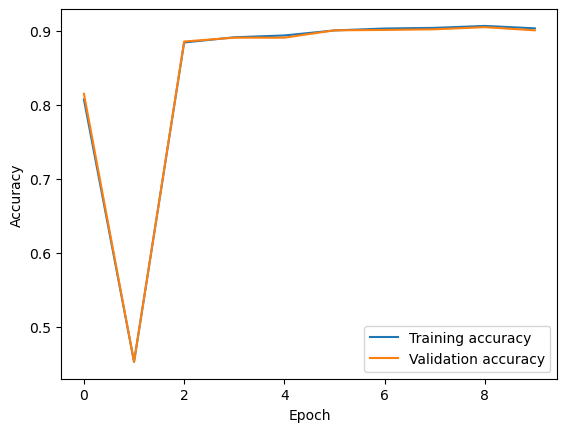

In [50]:
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10 # epoch
LR = [0.01, 1, 2]  # learning rate
BATCH_SIZE = 43 # batch size for training

criterion = torch.nn.CrossEntropyLoss()

accuracy_lr = []



# Collect the accuracy values at each epoch

for lr in LR:
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
  total_accu = None

  train_accuracies = []
  val_accuracies = []

  for epoch in range(1, EPOCHS + 1):
      # Train the model and collect the training accuracy
      epoch_start_time = time.time()
      train(train_dataloader)
      train_acc = evaluate(train_dataloader)
      train_accuracies.append(train_acc)
      
      # Evaluate the model and collect the validation accuracy
      val_acc = evaluate(test_dataloader)
      val_accuracies.append(val_acc)
      
      # Adjust the learning rate if the validation accuracy did not improve
      if total_accu is not None and total_accu > val_acc:
        scheduler.step()
      else:
        total_accu = val_acc
      
      print('-' * 59)
      print('| end of epoch {:3d} | time: {:5.2f}s | '
            'train accuracy {:8.3f} | val accuracy {:8.3f}'.format(epoch,
                                                                  time.time() - epoch_start_time,
                                                                  train_acc, val_acc))
      print('-' * 59)
 
  accuracy_lr.append(val_acc)

print(accuracy_lr)

# Plot the training and validation accuracies
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Evaluation
In dit laatste gedeelte ga ik bekijken hoe goed het model per intent werkt. <br>
Ik maak hiervoor eerst een nieuwe kolom aan waarin ik de voorspelde waardes zet. Hierna kan ik bekijken wat hier van overeen komt.

In [52]:
def predict(model, keyword):
    predicted_label = model(keyword)
    return np.argmax(predicted_label.detach().numpy(), axis=1)

predicted = predict(model, torch.tensor(np.array(input_ids)))
labelencoder.inverse_transform(predicted)

intent_keuken['predicted'] = labelencoder.inverse_transform(predicted)
intent_keuken

,Keyword,Intentie,tokenized,sequences,Label Encode,predicted
0,keuken,TRANS,[keuken],"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,TRANS
1,koelkast,TRANS,[koelkast],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,TRANS
2,inductie kookplaat,TRANS,"[inductie, kookplaat]","[18, 6, 0, 0, 0, 0, 0, 0, 0, 0]",3,TRANS
3,afzuigkap,TRANS,[afzuigkap],"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,TRANS
4,vaatwasser,TRANS,[vaatwasser],"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,TRANS
...,...,...,...,...,...,...
38659,groothandel keuken accessoires,TRANS,"[groothandel, keuken, accessoires]","[1861, 4, 185, 0, 0, 0, 0, 0, 0, 0]",3,LOCAL
38660,keuken accessoires groothandel,TRANS,"[keuken, accessoires, groothandel]","[4, 185, 1861, 0, 0, 0, 0, 0, 0, 0]",3,LOCAL
38661,roze keuken accessoires,TRANS,"[roze, keuken, accessoires]","[694, 4, 185, 0, 0, 0, 0, 0, 0, 0]",3,TRANS
38662,zwart wit keuken accessoires,TRANS,"[zwart, wit, keuken, accessoires]","[54, 73, 4, 185, 0, 0, 0, 0, 0, 0]",3,COM


Hieronder zie je dat 90% van de voorspelde waardes over de gehele dataset klopt.

In [53]:
sum(intent_keuken.predicted == intent_keuken.Intentie)/len(intent_keuken)

#maken classification rapport

0.9029588247465342

In [54]:
from sklearn.metrics import classification_report
y_true = intent_keuken.Intentie
y_pred = intent_keuken.predicted
target_names = ['COM', 'INFO', 'TRANS', 'LOCAL']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

         COM       0.89      0.61      0.73      3692
        INFO       0.84      0.72      0.78      3682
       TRANS       0.81      0.95      0.88      2891
       LOCAL       0.92      0.96      0.94     28399

    accuracy                           0.90     38664
   macro avg       0.87      0.81      0.83     38664
weighted avg       0.90      0.90      0.90     38664

